In [1]:
# --- MUST be first matplotlib cell in the notebook ---
import matplotlib
matplotlib.use('nbAgg')              # interactive backend for classic Notebook 5.x
%matplotlib notebook
print("Matplotlib backend:", matplotlib.get_backend())


Matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


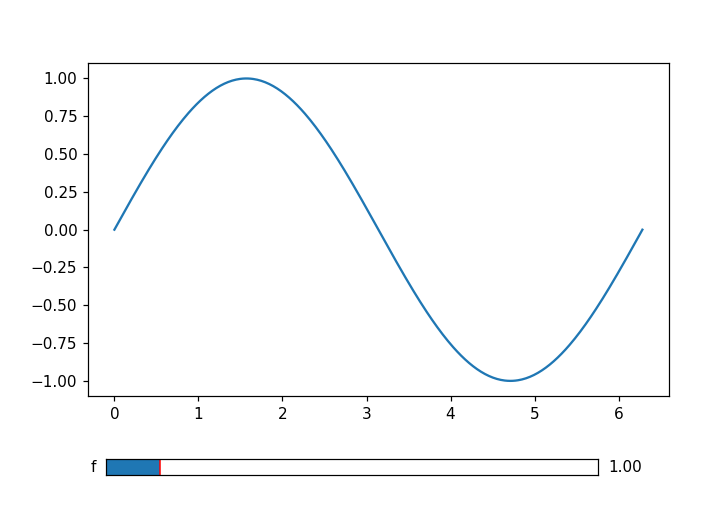

In [2]:
from matplotlib.widgets import Slider
import numpy as np, matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25, right=0.95)
x = np.linspace(0, 2*np.pi, 400)
(freq_ax) = plt.axes([0.15, 0.1, 0.7, 0.03])
s = Slider(freq_ax, 'f', 0.5, 5.0, valinit=1.0)
line, = ax.plot(x, np.sin(1.0*x))

def _upd(_=None):
    line.set_ydata(np.sin(s.val * x))
    fig.canvas.draw_idle()

s.on_changed(_upd)
_upd()


In [3]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
#%matplotlib inline
#import matplotlib.pyplot as plt

##### Set the path of code folder containing GANSim codes

In [4]:
new_path = r'/home/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/2_GANSimTraining/' 
sys.path.append(new_path)

### 1. Load test dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [5]:
data_dir_test = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/'

In [6]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = False, cond_prob = False,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# loaded labels (global features) have been normalized into -1 to 1
facies_label_thick_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = facies_label_thick_dict['real']
labels_test = facies_label_thick_dict['label']

# Denormalize the global features back into its orginal range 
orit_one_hot = labels_test[:, :30]
orit_class = np.argmax(orit_one_hot, axis = 1)
mudprop = labels_test[:, 30] 
mudprop = (mudprop / 2 + 0.5) * 0.8037 + 0.1677
width = labels_test[:, 31] 
width = (width / 2 + 0.5) * 8 + 27
wvl = labels_test[:, 32]
wvl = (wvl / 2 + 0.5) * 63 + 100
amplt = labels_test[:, 33]
amplt = (amplt / 2 + 0.5) * 104 + 7

print(facies_test.shape)
print(orit_one_hot.shape)
print(orit_class.shape)
print(mudprop.shape)
print(width.shape)
print(wvl.shape)
print(amplt.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000, 30)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


<IPython.core.display.Javascript object>


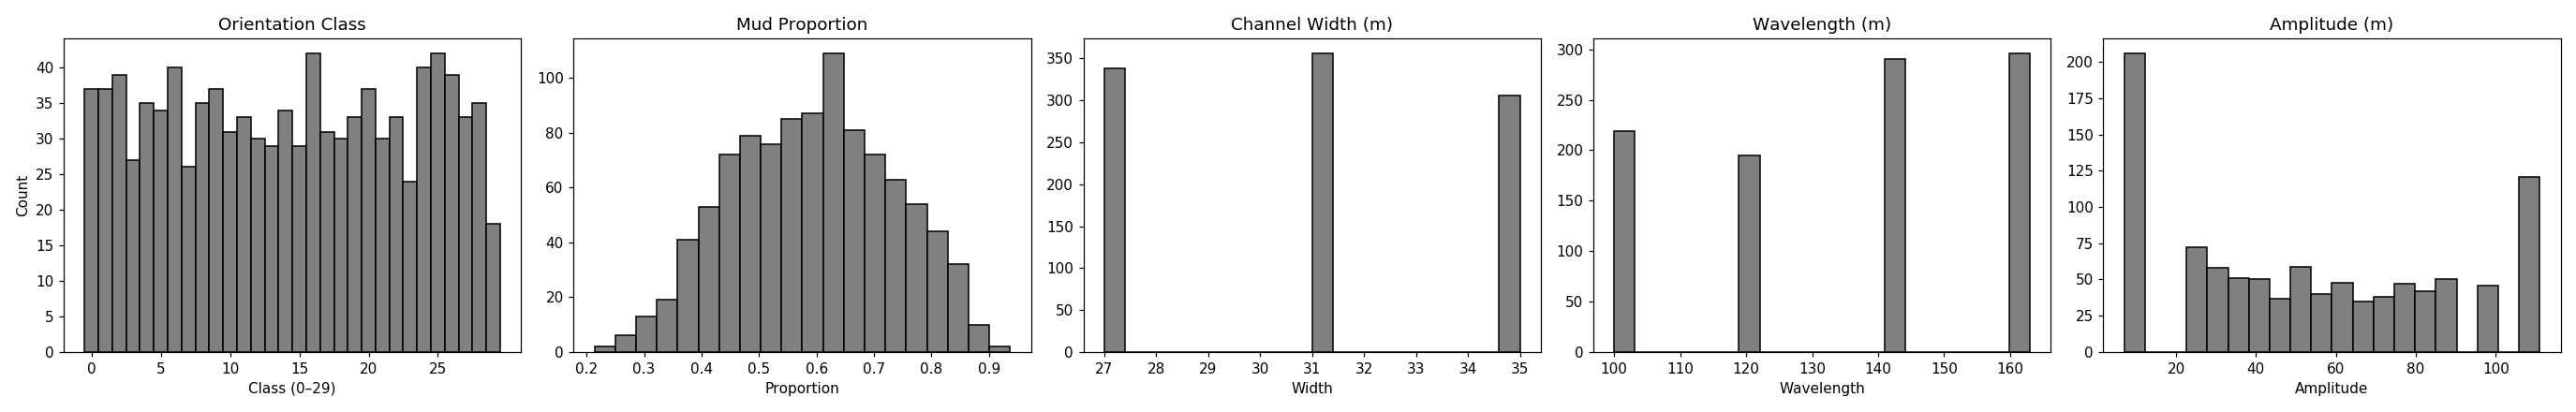

In [7]:
# Create 1-row, 5-column subplot layout
fig, ax = plt.subplots(1, 5, figsize=(25, 4))
plt.subplots_adjust(wspace=0.4)

# Plot orientation class histogram
ax[0].hist(orit_class, bins=np.arange(31)-0.5, color='gray', edgecolor='black')
ax[0].set_title('Orientation Class')
ax[0].set_xlabel('Class (0–29)')
ax[0].set_ylabel('Count')
ax[0].set_xticks(np.arange(0, 30, 5))

# Plot mud proportion histogram
ax[1].hist(mudprop, bins=20, color='gray', edgecolor='black')
ax[1].set_title('Mud Proportion')
ax[1].set_xlabel('Proportion')

# Plot width histogram
ax[2].hist(width, bins=20, color='gray', edgecolor='black')
ax[2].set_title('Channel Width (m)')
ax[2].set_xlabel('Width')

# Plot wavelength histogram
ax[3].hist(wvl, bins=20, color='gray', edgecolor='black')
ax[3].set_title('Wavelength (m)')
ax[3].set_xlabel('Wavelength')

# Plot amplitude histogram
ax[4].hist(amplt, bins=20, color='gray', edgecolor='black')
ax[4].set_title('Amplitude (m)')
ax[4].set_xlabel('Amplitude')

plt.tight_layout()
plt.show()


### 2. Train and load trained conditional generator

In [8]:
GANSim_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/GANSim_cond_gf/'
GANSim_name = 'network-snapshot-014720.pkl' 

recognizer_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/FeatureRecognizer/'
recognizer_name = 'network-snapshot-069520.pkl' 

generator_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/GANSim_unc/'
generator_name = 'network-snapshot-025921.pkl' 

# Initialize TensorFlow session.
tf.InteractiveSession()

with tf.device('/gpu:0'):   
    # Import Generator.
    with open(GANSim_dir+GANSim_name, 'rb') as file:
        _, _, Gs_Gansim = pickle.load(file)     
    
    # Import trained global feature recognizer
    with open(recognizer_dir + recognizer_name, 'rb') as file:
        _, R, _ = pickle.load(file)
        
    with open(generator_dir+generator_name, 'rb') as file:
        _, _, Gs_unc = pickle.load(file) 

print(Gs_Gansim.input_shapes)
print(Gs_Gansim.output_shapes)

print(R.input_shapes)
print(R.output_shapes)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[[None, 8, 4, 4], [None, 34, 64, 64], [None, 0, 64, 64], [None, 0, 64, 64]]
[[None, 3, 64, 64]]
[[None, 1, 64, 64], [None, 0, 64, 64]]
[[None, 1], [None], [None], [None, 34]]


#### Make 

<IPython.core.display.Javascript object>


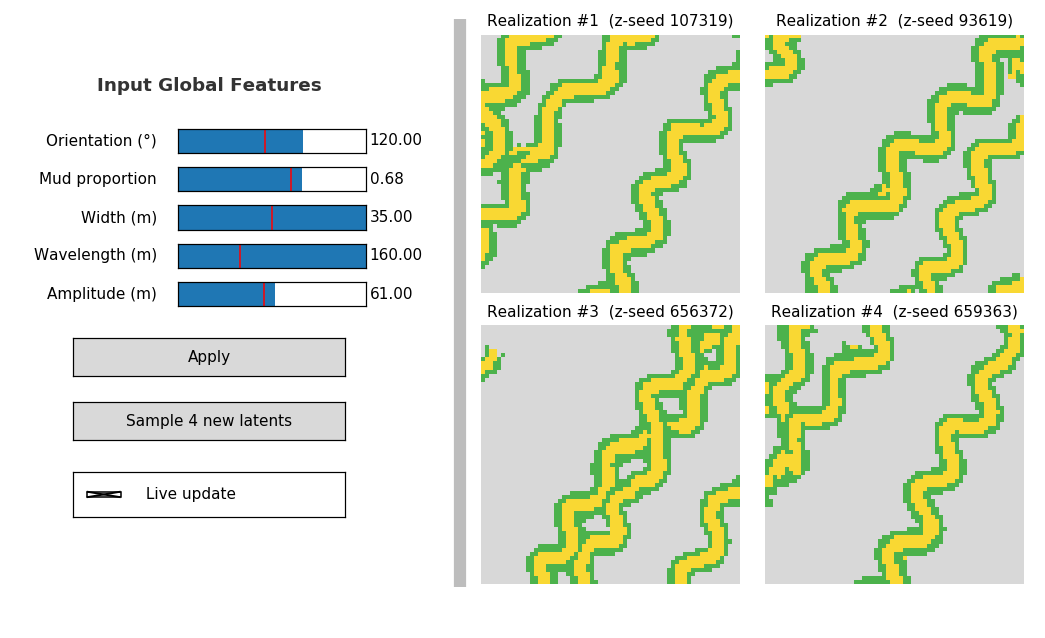

In [51]:

# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
from matplotlib.colors import ListedColormap

# ===== Helpers: match your notebook’s normalization =====
def norm_features(mudprop, width, wvl, amplt):
    width_n   = ((width   - 27)    / 8    - 0.5) * 2
    amplt_n   = ((amplt   - 7)     / 104  - 0.5) * 2
    wvl_n     = ((wvl     - 100)   / 63   - 0.5) * 2
    mudprop_n = ((mudprop - 0.1677) / 0.8037 - 0.5) * 2
    return mudprop_n, width_n, wvl_n, amplt_n

def build_label(orientation_deg, mudprop, width, wvl, amplt):
    cls = int(np.clip(np.floor(orientation_deg / 6.0), 0, 29))  # 30 classes over 0–180°
    one_hot = np.zeros(30, dtype=np.float32); one_hot[cls] = 1.0
    m, w, wl, a = norm_features(mudprop, width, wvl, amplt)
    return np.concatenate([one_hot, [m, w, wl, a]]).astype(np.float32)  # (34,)

def vector_to_maps(label_vec, H=64, W=64, B=4):
    lab_hw = np.broadcast_to(label_vec[:, None, None], (label_vec.shape[0], H, W)).astype(np.float32)  # (34,H,W)
    return np.broadcast_to(lab_hw[None, ...], (B, lab_hw.shape[0], H, W)).copy()                       # (B,34,H,W)

# ===== Fixed latents + empty constraints (distinct latents per panel) =====
B = 4
H = W = 64
Z_SHAPE = (8, 4, 4)  # <- change if your latent shape differs

rng = np.random.RandomState(412)

def _latents_from_seeds(seeds, z_shape=Z_SHAPE):
    """Build a (B, *z_shape) tensor with one different latent per seed."""
    return np.stack(
        [np.random.RandomState(int(s)).randn(*z_shape).astype(np.float32) for s in seeds],
        axis=0
    )

# pick 4 different seeds and make 4 different latents
seeds = rng.randint(0, 1_000_000, size=B)
latents_fixed = _latents_from_seeds(seeds)

# no well/prob constraints
wellfacies_zeros = np.zeros((B, 0, H, W), dtype=np.float32)
prob_zeros       = np.zeros((B, 0, H, W), dtype=np.float32)


# ===== Colormap (class ids: 0=background, 1=levee, 2=channel-center) =====
bg_gray   = [0.85, 0.85, 0.85]
levee_grn = [0.30, 0.70, 0.30]
center_yl = [0.98, 0.85, 0.20]
facies_cmap = ListedColormap([bg_gray, levee_grn, center_yl])
VMAX = 2  # max class index

# ===== Figure: controls LEFT, realizations RIGHT; tighter spacing =====
fig, axes = plt.subplots(2, 2, figsize=(9.5, 5.8))
# leave room on the left; pack images closer with smaller hspace/wspace
plt.subplots_adjust(left=0.46, right=0.98, bottom=0.08, top=0.95, hspace=0.1, wspace=0.1)
for ax in axes.flat:
    ax.axis('off')

# ---- Left control panel geometry ----
# Total control panel box
x_panel, w_panel = 0.05, 0.3
# Split each row into a label box and a slider box
w_label = 0.1
w_slider = w_panel - w_label - 0.02  # 0.02 gap
y = 0.76
row_h = 0.038
row_gap = 0.06

def _make_label(ax_rect, text):
    ax = plt.axes(ax_rect, frameon=False)
    ax.set_xticks([]); ax.set_yticks([])
    ax.text(1.0, 0.5, text, ha='right', va='center', fontsize=10)
    return ax

# ---- Title above the control panel ----
# center of the left control panel
panel_cx = x_panel + w_panel/2.0
# y-position a bit above the top slider row
title_y  = 0.88   # tweak (0.94–0.97) if you want it higher/lower

fig.text(
    panel_cx, title_y,
    "Input Global Features",
    ha="center", va="top",
    fontsize=12, fontweight="bold", color="#333333",
    transform=fig.transFigure
)
# Orientation
lab_deg = _make_label([x_panel, y, w_label, row_h], 'Orientation (°)')
ax_deg  = plt.axes([x_panel + w_label + 0.02, y, w_slider, row_h]); y -= row_gap
# Mud proportion
lab_mud = _make_label([x_panel, y, w_label, row_h], 'Mud proportion')
ax_mud  = plt.axes([x_panel + w_label + 0.02, y, w_slider, row_h]); y -= row_gap
# Width
lab_wd  = _make_label([x_panel, y, w_label, row_h], 'Width (m)')
ax_wd   = plt.axes([x_panel + w_label + 0.02, y, w_slider, row_h]); y -= row_gap
# Wavelength
lab_wl  = _make_label([x_panel, y, w_label, row_h], 'Wavelength (m)')
ax_wl   = plt.axes([x_panel + w_label + 0.02, y, w_slider, row_h]); y -= row_gap
# Amplitude
lab_amp = _make_label([x_panel, y, w_label, row_h], 'Amplitude (m)')
ax_amp  = plt.axes([x_panel + w_label + 0.02, y, w_slider, row_h]); y -= 0.11

# Buttons / toggle
ax_apply  = plt.axes([x_panel + 0.02, y, w_panel - 0.04, 0.060]); y -= 0.10
ax_latent = plt.axes([x_panel + 0.02, y, w_panel - 0.04, 0.060]); y -= 0.12
ax_live   = plt.axes([x_panel + 0.02, y, w_panel - 0.04, 0.07 ])

# ---- Create sliders / buttons ----
s_deg = Slider(ax_deg, '', 0, 180,   valinit=84,   valstep=6)
s_mud = Slider(ax_mud, '', 0.35, 0.85, valinit=0.65, valstep=0.03)
s_wd  = Slider(ax_wd,  '', 27, 35,  valinit=31,   valstep=4)
s_wl  = Slider(ax_wl,  '', 100, 160, valinit=120, valstep=20)
s_amp = Slider(ax_amp, '', 7, 111,   valinit=55,  valstep=3)

btn_apply  = Button(ax_apply,  'Apply')
btn_latent = Button(ax_latent, 'Sample 4 new latents')
chk_live   = CheckButtons(ax_live, [' Live update'], [True])

# ---- Vertical divider (bold gray straight line) ----
from matplotlib.lines import Line2D
sep_x = 0.44  # figure fraction (0..1)
divider = Line2D(
    [sep_x, sep_x],     # x-coords in figure space
    [0.08, 0.97],       # y-coords in figure space
    transform=fig.transFigure,
    color='#bdbdbd',    # gray
    linewidth=8,        # bold
    solid_capstyle='butt',
    zorder=3
)
fig.add_artist(divider)



# ===== Render + callbacks =====
live = True
def _toggle_live(_label):
    global live
    live = not live
chk_live.on_clicked(_toggle_live)

def _render():
    """Draw 4 realizations with current slider values."""
    try:
        label_vec = build_label(s_deg.val, s_mud.val, s_wd.val, s_wl.val, s_amp.val)   # (34,)
        labels = vector_to_maps(label_vec, H, W, B)                                     # (B,34,H,W)

        # Run trained generator
        indicators = Gs_Gansim.run(latents_fixed, labels, wellfacies_zeros, prob_zeros) # (B,C,H,W)
        cls_maps = np.argmax(indicators, axis=1)                                        # (B,H,W)

        for i, ax in enumerate(axes.flat):
            ax.clear()
            ax.imshow(cls_maps[i], cmap=facies_cmap, vmin=0, vmax=VMAX, interpolation='nearest')
            ax.set_title(f"Realization #{i+1}  (z-seed {int(seeds[i])})", fontsize=10)
            ax.axis('off')

        fig.canvas.draw_idle()
        plt.pause(0.001)  # helps ensure refresh on older stacks
    except Exception as e:
        import traceback, sys
        print("Render error:", e)
        traceback.print_exc(file=sys.stdout)

def _on_slider(_):
    if live:
        _render()

def _resample_latents(_event=None):
    """Resample all four latents to NEW, DISTINCT values."""
    global seeds, latents_fixed
    seeds = rng.randint(0, 1_000_000, size=B)
    latents_fixed = _latents_from_seeds(seeds)
    _render()

for s in (s_deg, s_mud, s_wd, s_wl, s_amp):
    s.on_changed(_on_slider)
btn_apply.on_clicked(lambda evt: _render())
btn_latent.on_clicked(_resample_latents)

# Initial draw
_render()
